In [4]:
import pandas as pd
import numpy as np

# Read the CSV file
data = pd.read_csv('connect4_dataset.csv')
data.head()

# Select columns pos01 to pos42
columns = [f'pos_{i:02d}' for i in range(1, 43)]
data.columns = columns + ['winner']
X_ = data[columns]
y = data['winner']

# Function to convert each row to a 6x7 2D array
def row_to_2d_array(row):
    return np.array(row).reshape(6, 7)

# Apply the function to each row
X = X_.apply(row_to_2d_array, axis=1)

Table:
 [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0 -1  0  0  1  0  0]
 [ 0 -1  0  0 -1  0  0]
 [ 1  1  1 -1  1 -1  0]
 [ 1  1 -1 -1 -1  1  0]]
Winner: 0


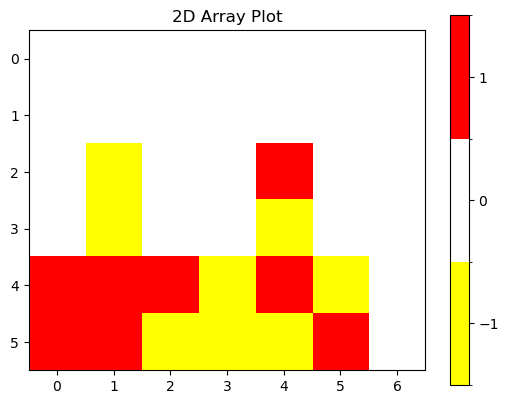

In [6]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

game_num = 2

# Assuming data_2d_arrays is already defined and contains the 2D arrays
# Display the 2D array for the a row
print('Table:\n', X[game_num])
print('Winner:', y[game_num])

array_to_plot = X.iloc[game_num]

# Define a custom colormap
cmap = mcolors.ListedColormap(['yellow', 'white', 'red'])
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the 2D array
plt.imshow(array_to_plot, cmap=cmap, norm=norm)
plt.colorbar(ticks=[-1, 0, 1])
plt.title('2D Array Plot')
plt.show()

# Logistic Regression Classifier

  Very naive model that only actually learns if a board is won or not and by who.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Flatten the 6x7 2D arrays back to 1D arrays for logistic regression
X_flat = X.apply(lambda x: x.flatten())
X_flat = np.stack(X_flat.values)

# Drop rows with NaN values in y
non_nan_indices = ~np.isnan(y)
X_flat = X_flat[non_nan_indices]
y = y[non_nan_indices]

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')

Accuracy: 0.712


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Multilayer Perceptron (MLP) Classifiers

Pretty naive approach, but it should still work in theory. Other models like Random Forest, SVM, etc, should be tried to see if they perform better.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np

import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('Old Code/c4_game_database.csv', on_bad_lines='skip')

# Prepare the features (X) and the target labels (y)
X = data.drop(columns=['winner']).values
y_winner = data['winner'].values

# Convert the 'winner' column into a 7-element probability vector
y = np.zeros((len(y_winner), 7))

y[y_winner == 1] = 1    # If Player 1 won, set all columns to 1
y[y_winner == -1] = 0   # If Player 2 won, set all columns to 0
y[y_winner == 0] = 0.5  # If tie, set all columns to 0.5

# Check the shapes of X and y
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (376640, 42)
y shape: (376640, 7)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the MLP model
class Connect4MLP(nn.Module):
    def __init__(self):
        super(Connect4MLP, self).__init__()
        self.fc1 = nn.Linear(42, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 7)   # Output layer (7 probabilities for each column)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid to output probabilities
        return x

# Initialize the model, loss function, and optimizer
model2 = Connect4MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model2(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation on test set
model2.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test).item()
    print(f'Loss on test set: {test_loss:.4f}')

Epoch [10/50], Loss: 0.2392
Epoch [20/50], Loss: 0.2359
Epoch [30/50], Loss: 0.2291
Epoch [40/50], Loss: 0.2181
Epoch [50/50], Loss: 0.2058
Loss on test set: 0.2051


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Convert data to torch tensors, reshaping X for MLP input
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 42)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 42)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the MLP model
class Connect4MLP(nn.Module):
    def __init__(self):
        super(Connect4MLP, self).__init__()
        self.fc1 = nn.Linear(42, 64)   # Input layer with 42 features
        self.fc2 = nn.Linear(64, 128)  # Hidden layers
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 32)
        self.fc9 = nn.Linear(32, 7)    # Output layer (7 probabilities for each column)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = torch.sigmoid(self.fc9(x))  # Sigmoid to output probabilities
        return x

# Initialize the model, loss function, and optimizer
model = Connect4MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    
    # Calculate loss
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


# Evaluation on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test).item()
    print(f'Loss on test set: {test_loss:.4f}')

Epoch [10/50], Loss: 0.2405
Epoch [20/50], Loss: 0.2322


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 6, 7)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 6, 7)
y_test = torch.tensor(y_test, dtype=torch.float32)

class Connect4CNN(nn.Module):
    def __init__(self):
        super(Connect4CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 6 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 7)  # Output layer (7 probabilities for each column)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid to output probabilities
        return x

model3 = Connect4CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model3.train()
    optimizer.zero_grad()
    outputs = model3(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

model3.eval()
with torch.no_grad():
    test_outputs = model3(X_test)
    test_loss = criterion(test_outputs, y_test).item()
    print(f'Loss on test set: {test_loss:.4f}')

Epoch [10/50], Loss: 0.2330
Epoch [20/50], Loss: 0.1974


# SVM

In [16]:
from sklearn import svm

data = pd.read_csv('Old Code/c4_game_database.csv')
data = data.dropna()

columns = [f'pos_{i:02d}' for i in range(1, 43)]
X = data[columns]
y = data['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")


# Results:

Running this cell will give you the probabilities of winning given a placement in each column. There are 7 outputs, one for each column in the Connect Four game. The model outputs a probability for each column, indicating the likelihood of winning if a piece is placed in that column. The column with the highest probability is the best move to make.

In [13]:
new_data = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, -1, 1, 0, 0],
    [0, 1, -1, 1, -1, 0, 0],
    [1, -1, 1, -1, 1, 0, 0],
    [-1, 1, -1, 1, -1, 1, 0],
    [1, -1, 1, -1, 1, -1, 1]
], dtype=np.float32)

# Convert to tensor and reshape to match (1, 1, 6, 7) format for the model
new_data_tensor = torch.tensor(new_data, dtype=torch.float32).reshape(1, 1, 6, 7)

# Set the model to evaluation mode
model = Connect4CNN()
model.eval()

# Make predictions
with torch.no_grad():
    prediction = model(new_data_tensor)
    prediction_np = prediction.numpy().flatten()

    # Find the best column (index of the highest probability)
    best_column = np.argmax(prediction_np)
    print("Probabilities for each column:", prediction_np)
    print("Best column to play:", best_column)

Prediction: [[0.5338113  0.5198696  0.5356338  0.51042956 0.53341067 0.47715053
  0.5103585 ]]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Assuming `X` contains the 42 board positions reshaped as (num_samples, 6, 7)
# and `y` contains the 7 probability targets for each move
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to torch tensors, reshaping X for CNN input
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 1, 6, 7)  # Add channel dimension
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32).reshape(-1, 1, 6, 7)    # Add channel dimension
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the more complex CNN model
class Connect4CNNComplex(nn.Module):
    def __init__(self):
        super(Connect4CNNComplex, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output size: 32x6x7
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Output size: 64x6x7
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Output size: 128x6x7
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(128 * 6 * 7, 256)   # Flatten and dense layer
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 7)  # Output layer (7 probabilities for each column)

    def forward(self, x):
        # Apply convolutions with batch norm and ReLU activations
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        
        # Flatten and pass through fully connected layers with Dropout and ReLU
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.dropout1(self.fc1(x)))
        x = torch.relu(self.dropout2(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid to output probabilities
        return x

# Initialize the model, loss function, and optimizer
model = Connect4CNNComplex()
criterion = nn.MSELoss()  # Mean Squared Error loss for regression on probabilities
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluation on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test).item()
    print(f'Loss on test set: {test_loss:.4f}')

In [ ]:
new_data = np.array([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, -1, 1, 0, 0],
    [0, 1, -1, 1, -1, 0, 0],
    [1, -1, 1, -1, 1, 0, 0],
    [-1, 1, -1, 1, -1, 1, 0],
    [1, -1, 1, -1, 1, -1, 1]
], dtype=np.float32)

# Convert to tensor and reshape to match (1, 1, 6, 7) format for the model
new_data_tensor = torch.tensor(new_data, dtype=torch.float32).reshape(1, 1, 6, 7)

# Set the model to evaluation mode
model = Connect4CNN()
model.eval()

# Make predictions
with torch.no_grad():
    prediction = model(new_data_tensor)
    prediction_np = prediction.numpy().flatten()

    # Find the best column (index of the highest probability)
    best_column = np.argmax(prediction_np)
    print("Probabilities for each column:", prediction_np)
    print("Best column to play:", best_column)